#### Data was published and collected from https://www.sciencedirect.com/science/article/pii/S2352340918315191

# Data Preprocessing

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('hotel_bookings.csv')
data.head()
# data.shape

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [3]:
# Checking Data Types and Attributes
# data.info()
# Checking for Empty Data
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
# Deleting columns with a high number of empty data
data = data.drop('company', axis = 1)

In [5]:
# Modify data so that it is more appropriate
data = data.fillna({
    'children' : 0,
    'agent' : 0,
    'country': 'Unknown',
})

In [6]:
# Check whether missing data exist
any(data.isna().sum())

False

In [7]:
# Upon observation, there are rows where a room was booked but adult,children, and babies are zero
# Dropping this data since it is impossible for a room to be booked without a single visitor staying
# Might be cause from error during data collection process

zero_guests = list(data.loc[data["adults"]
                   + data["children"]
                   + data["babies"]==0].index)
data.drop(data.index[zero_guests], inplace=True)
# data.shape

# Exploratory Data Analysis(EDA) 

## Detecting and Removing Outliers

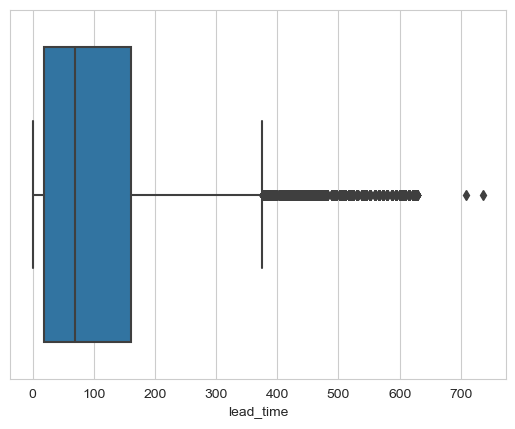

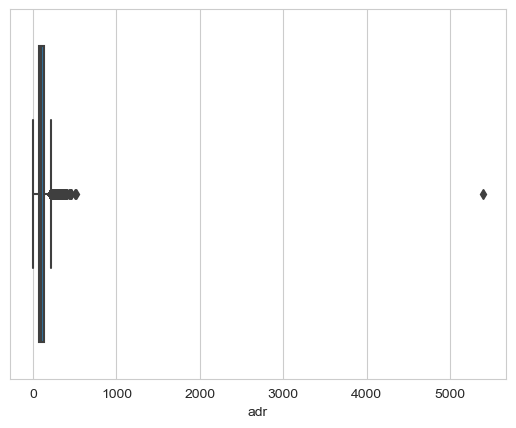

In [8]:
# LeadTime is result of subtraction of the entering date from the arrival date
sns.boxplot(data=data, x = 'lead_time')
plt.show()

# Average Daily Rate(adr) is result of dividing the sum of all lodging transactions by the total number of staying nights
sns.boxplot(data=data, x = 'adr')
plt.show()

In [9]:
# Interquartile Range of lead time
IQR_lt = data['lead_time'].quantile(0.75) -  data['lead_time'].quantile(0.25)
IQR_adr = data['adr'].quantile(0.75) -  data['adr'].quantile(0.25)
# Applying the 1.5 rule and remove the outliers
temp1 = data['lead_time'].quantile(0.75) + 1.5*IQR_lt
temp2 = data['adr'].quantile(0.75) + 1.5*IQR_adr
data_clean = data[data['lead_time'] <= temp1] 
data_clean = data_clean[data_clean['adr'] <= temp2] # new data with no outliers

## Distribution of which country are the guest coming from 

In [10]:
dt_country = pd.DataFrame(data.loc[data['is_canceled'] != 1]['country'].value_counts())
dt_country.index.name = 'country'
dt_country.rename(columns={"country": "Number of Guests"}, inplace=True)
number_of_guests = dt_country["Number of Guests"].sum()
dt_country["Guests in %"] = round(dt_country["Number of Guests"] / number_of_guests * 100, 2)
dt_country.head(10)

,Number of Guests,Guests in %
country,,
PRT,20977,27.97
GBR,9668,12.89
FRA,8468,11.29
ESP,6383,8.51
DEU,6067,8.09
IRL,2542,3.39
ITA,2428,3.24
BEL,1868,2.49
NLD,1716,2.29


#### Based on the data shown above, most of the guest are coming from Portugal

In [11]:
# pip install plotly

In [43]:
import plotly.express as px
guest_map = px.choropleth(dt_country,
                    locations=dt_country.index,
                    color=dt_country["Guests in %"], 
                    hover_name=dt_country.index, 
                    title="Country of Origin of Guests")
guest_map.show()

## Amount of guests based on hotels each year

In [13]:
guest_data = data[data['is_canceled'] == 0].copy()
guests_monthly = guest_data[['hotel', 'arrival_date_year', 'arrival_date_month', 'adults', 'children', 'babies']].sort_values('arrival_date_year')
guests_monthly['total visitors'] = guests_monthly['adults'] + guests_monthly['children'] + guests_monthly['babies']
guests_monthly = guests_monthly.astype({'total visitors' : int})
guests_monthly = guests_monthly.drop(['adults', 'children', 'babies'], axis=1)
guests_monthly.head()

,hotel,arrival_date_year,arrival_date_month,total visitors
0,Resort Hotel,2015,July,2
43256,City Hotel,2015,September,2
43257,City Hotel,2015,September,2
43258,City Hotel,2015,September,2
43259,City Hotel,2015,September,2


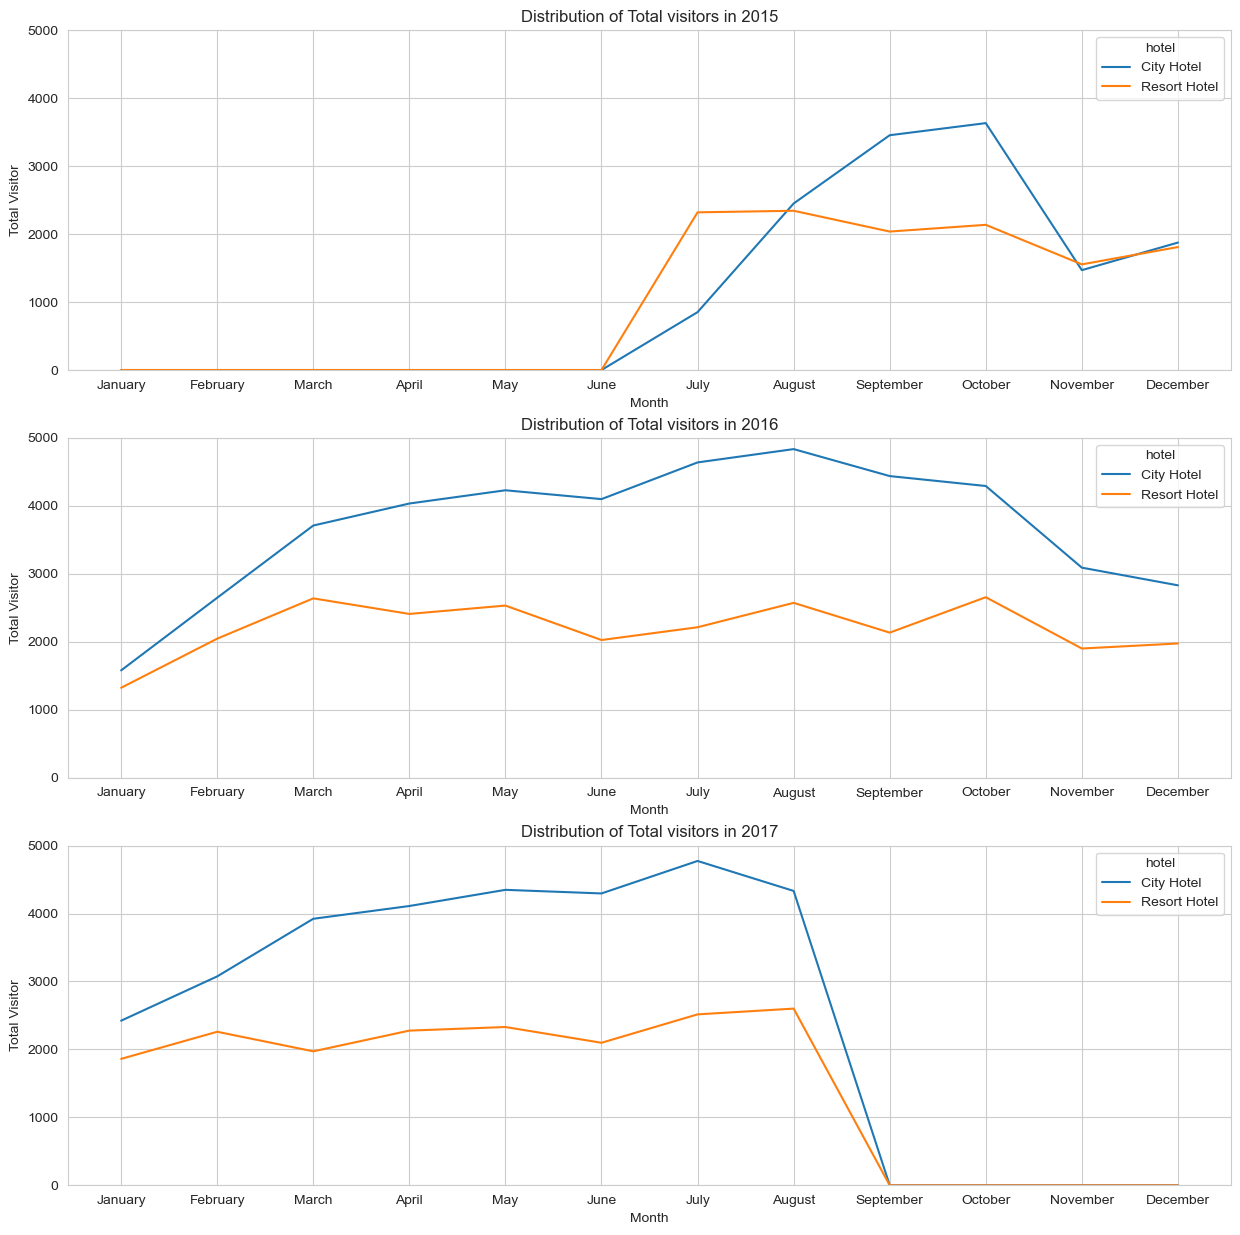

In [14]:
months_dict = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

guests_monthly['arrival_date_month'] = pd.Categorical(guests_monthly['arrival_date_month'], categories=months_dict, ordered=True)

guests_monthly = guests_monthly.groupby(['hotel', 'arrival_date_year', 'arrival_date_month'], as_index = False).sum()
f, ax = plt.subplots(3,1,figsize=(15,15))
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2015],  ci="sd", ax=ax[0])
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2016],  ci="sd", ax=ax[1])
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2017],  ci="sd", ax=ax[2])

ax[0].set(title="Distribution of Total visitors in 2015")
ax[0].set(xlabel="Month", ylabel="Total Visitor")
ax[0].set(ylim = (0,5000))

ax[1].set(title="Distribution of Total visitors in 2016")
ax[1].set(xlabel="Month", ylabel="Total Visitor")
ax[1].set(ylim = (0,5000))

ax[2].set(title="Distribution of Total visitors in 2017")
ax[2].set(xlabel="Month", ylabel="Total Visitor")
ax[2].set(ylim = (0,5000))

plt.show()

### Based on the graphs above, the distribution is not always as constant as what was predicted. The are some similarities on the trend in increasing amount of visitor each year and this always happens between June to August. This might be cause by school holidays and families deciding to travel during mid-year break. Further survey can be done to find reasons on the increase on the number of visitors during these months. 



## Total cost based on room type per night

In [15]:
pd.options.mode.chained_assignment = None  # default='warn'
# Separate data based on room type
resort_hotel = data_clean[(data_clean['hotel'] == 'Resort Hotel') & (data_clean['is_canceled'] == 0)]
city_hotel = data_clean[(data_clean['hotel'] == 'City Hotel') & (data_clean['is_canceled'] == 0)]

resort_hotel['adr_pp'] = resort_hotel['adr'] / (resort_hotel['adults'] + resort_hotel['children'])
city_hotel['adr_pp'] = city_hotel['adr'] / (city_hotel['adults'] + city_hotel['children'])

### It is assumed that the curency used for transaction is Euro €, since most guest are from Portugal

In [16]:
print(f"""
    Average price paid per person per night is:
    Resort Hotel: {resort_hotel['adr_pp'].mean():.2f} €
    City Hotel: {city_hotel['adr_pp'].mean():.2f} €""" 
    )


    Average price paid per person per night is:
    Resort Hotel: 44.50 €
    City Hotel: 58.82 €


In [17]:
raw_data_copy = data.copy()
raw_data_copy = raw_data_copy.loc[raw_data_copy['is_canceled'] == 0]
raw_data_copy['adr_pp'] = raw_data_copy['adr'] / (raw_data_copy['adults'] + raw_data_copy['children'])
room_prices = raw_data_copy[['hotel', 'reserved_room_type', 'adr_pp']].sort_values("reserved_room_type")

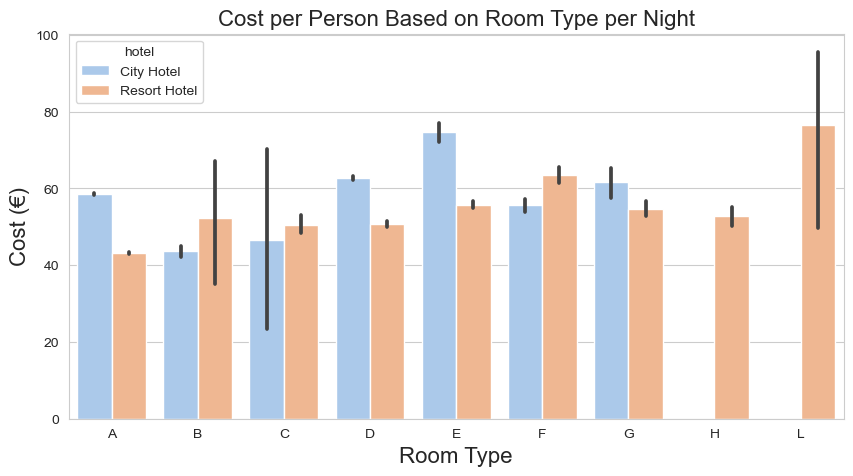

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(x='reserved_room_type', y='adr_pp', hue='hotel', data=room_prices, hue_order=['City Hotel', 'Resort Hotel'], palette='pastel')
plt.title('Cost per Person Based on Room Type per Night', fontsize=16)
plt.xlabel('Room Type', fontsize = 16)
plt.ylabel('Cost (€)', fontsize = 16)
plt.show()

### From the graph above, it was observed that Resort Hotel have the most expensive Room Type which is room L. In general the price difference for each room type is not that significant except for room type E in City Hotel which is way more expensive than in Resort Hotel.

## Most ordered Room Type

In [19]:
print('Booking Frequency for each Room Type in City Hotel')
print(data[(data['hotel'] == 'City Hotel')]['reserved_room_type'].value_counts())
print('------------------------------------------------------------------')
print('Booking Frequency for each Room Type in Resort Hotel')
print(data[data['hotel'] == 'Resort Hotel']['reserved_room_type'].value_counts())

Booking Frequency for each Room Type in City Hotel
A    62484
D    11747
F     1788
E     1537
B     1112
G      482
C       13
Name: reserved_room_type, dtype: int64
------------------------------------------------------------------
Booking Frequency for each Room Type in Resort Hotel
A    23389
D     7432
E     4982
G     1610
F     1106
C      918
H      601
L        6
B        3
Name: reserved_room_type, dtype: int64


<AxesSubplot:xlabel='reserved_room_type', ylabel='count'>

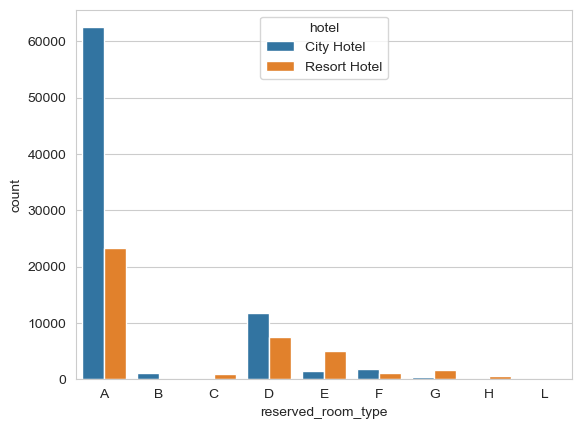

In [20]:
sns.countplot(x = 'reserved_room_type', data = data.sort_values('reserved_room_type'), hue='hotel') 

## Market Segment Comparison based on Hotel

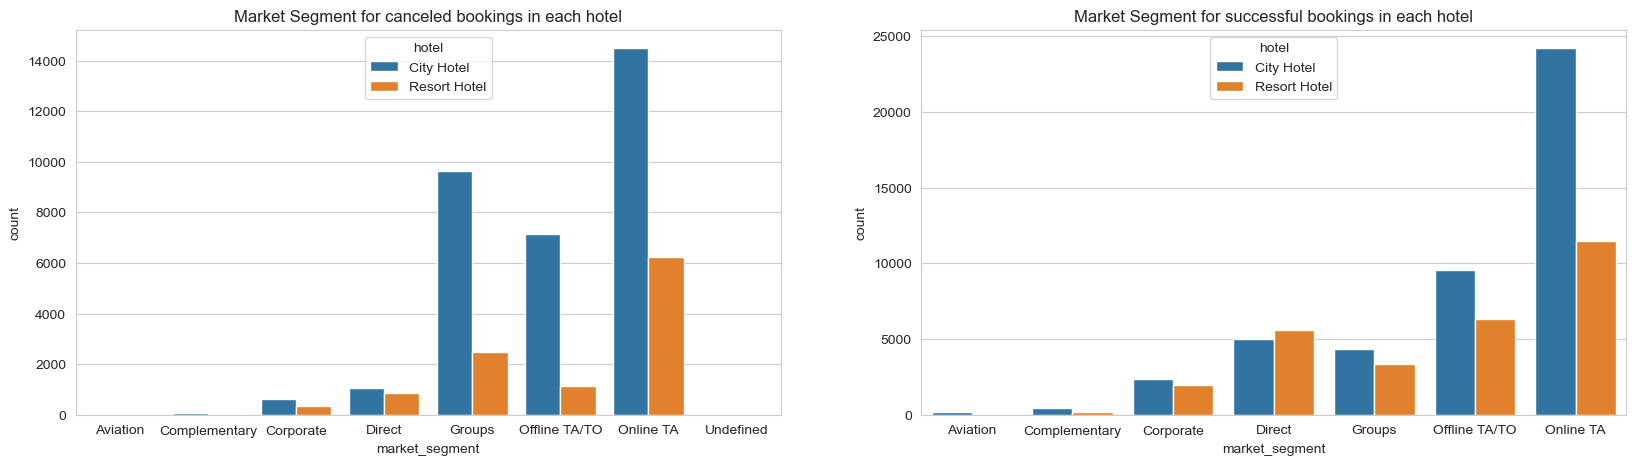

In [30]:
canceled = data[data['is_canceled'] == 1].sort_values('market_segment')
not_canceled = data[data['is_canceled'] == 0].sort_values('market_segment')
f, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=canceled, x= 'market_segment', hue='hotel', ax =ax[0])
sns.countplot(data=not_canceled, x= 'market_segment', hue='hotel', ax =ax[1])
ax[0].set(title='Market Segment for canceled bookings in each hotel')
ax[1].set(title='Market Segment for successful bookings in each hotel')
plt.show()

### Based on this, It was deduced that bookings made by groups for City Hotel have more risk of being canceled regardless of market segment. Most of the hotels are booked through an online TA

## Investigating Correlation between all Features 

<AxesSubplot:>

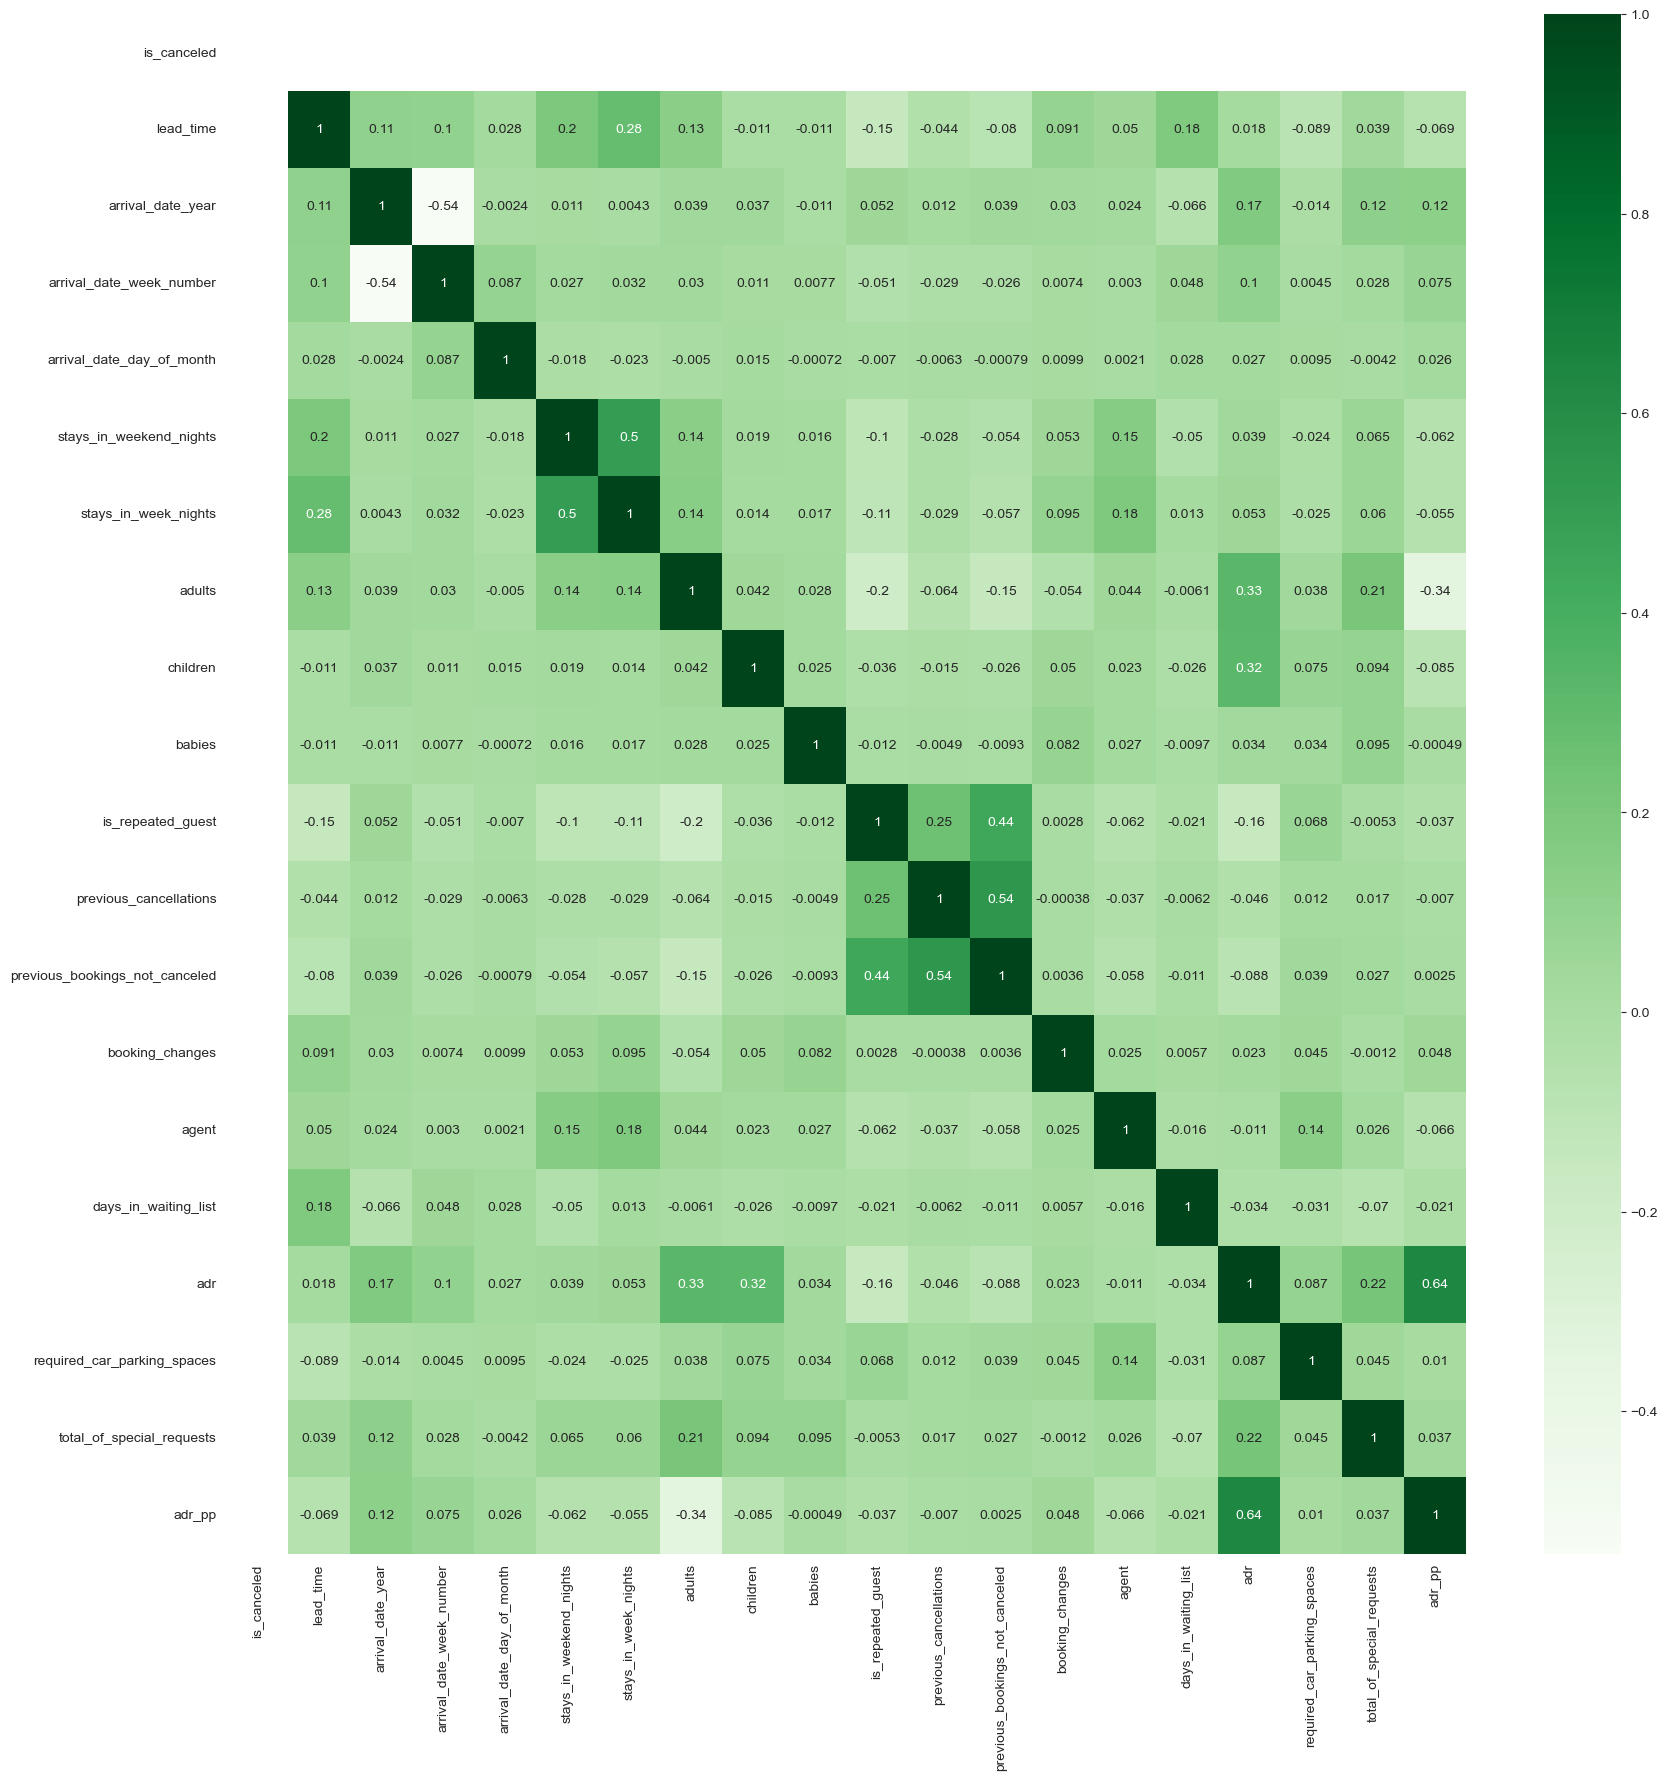

In [32]:
plt.figure(figsize=(20, 20))
sns.heatmap(raw_data_copy.corr(), annot=True, cmap='Greens')

### It was observed that there is a direct correlation between:
### 1. lead_time and is_cancelled
### Bookings have a higher chance of getting cancelled for customers that have booked it in advance. This is might be caused by plans that are made in advance have to change due to unforeseen events. The other reasons of cancellations might also include natural disaster or sudden illnesses.  
### 2. previous_bookings_not_cancelled and is_repeated
### Most of the bookings that are made repeatedly have a lower chance of getting canceled. This is because of the fact that the customer are satisfied with the services provided at the hotel. Important insight from this is that if the cancellation rate was reduced, there will be a higher chance of repeated bookings.